# Histopathologic Cancer Detection
###### Identify metastic tissue in histopathologic scans of lymph node sections

## Imports

In [10]:
%matplotlib inline

import os
import cv2
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import time

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Activation, Input, Lambda
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

## Parameters

In [27]:
model_name = "ResNet50_pretrained"

## Load Data

In [11]:
train_X = []
train_y = []

df = pd.read_csv('dataset\\train_labels.csv')

for index, row in df.iterrows():
    img_id = row["id"]
    train_X.append(cv2.imread(f'dataset\\train\\{img_id}.tif'))
    
    train_y.append(row["label"])
    
train_X = np.array(train_X)
train_y = np.array(train_y)
    

In [12]:
print(train_X.shape)
print(train_y.shape)

(220025, 96, 96, 3)
(220025,)


## Display a randomly selected image

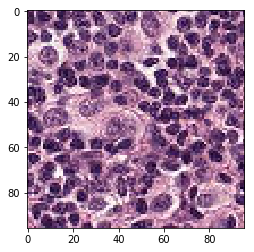

In [13]:
for img in train_X[np.random.choice(len(train_X), size=1, replace=False)]:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

## Define Model

### ResNet50 - Untrained

In [ ]:
img_input = Input(shape=(96,96,3))
norm = Lambda(lambda x: ((x/255.0) - 0.5))(img_input)

resnet = ResNet50(include_top=False, weights=None,input_tensor=norm, input_shape=(96,96,3), pooling='max')
x = resnet.output
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=img_input, outputs=output)
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5", monitor='val_acc', verbose=1,save_best_only=False, mode='min')

### ResNet50 - Pretrained 

In [ ]:
img_input = Input(shape=(96,96,3))
norm = Lambda(lambda x: ((x/255.0) - 0.5))(img_input)

resnet = ResNet50(include_top=False, weights='imagenet',input_tensor=norm, input_shape=(96,96,3), pooling='max')
x = resnet.output
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=img_input, outputs=output)
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
checkpoint = ModelCheckpoint("models\\" + model_name + "_{epoch:03d}_{val_acc:.4f}.h5", monitor='val_acc', verbose=1,save_best_only=False, mode='min')

## Train Model 

In [ ]:
history = model.fit(train_X, train_y, validation_split=0.2, callbacks=[checkpoint], epochs=50)

Train on 176020 samples, validate on 44005 samples
Epoch 1/50
176000/176020 [============================>.] - ETA: 0s - loss: 0.4794 - acc: 0.8176
Epoch 00001: val_loss improved from inf to 0.67860, saving model to models\ResNet50_pretrained_001_0.7271.h5
176020/176020 [==============================] - 643s 4ms/step - loss: 0.4794 - acc: 0.8176 - val_loss: 0.6786 - val_acc: 0.7271
Epoch 2/50
176000/176020 [============================>.] - ETA: 0s - loss: 0.5012 - acc: 0.8205
Epoch 00002: val_loss improved from 0.67860 to 0.34992, saving model to models\ResNet50_pretrained_002_0.8506.h5
176020/176020 [==============================] - 563s 3ms/step - loss: 0.5012 - acc: 0.8205 - val_loss: 0.3499 - val_acc: 0.8506
Epoch 3/50
176000/176020 [============================>.] - ETA: 0s - loss: 0.4471 - acc: 0.8202- ETA: 2s -
Epoch 00003: val_loss did not improve from 0.34992
176020/176020 [==============================] - 562s 3ms/step - loss: 0.4471 - acc: 0.8202 - val_loss: 0.7277 - val

## Plot and Save Results

In [ ]:
fig_acc = plt.figure()
ax1 = plt.subplot(111)
ax1.plot(history['acc'])
ax1.plot(history['val_acc'])
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig("figures\\" + model_name + "_acc.png")
plt.show()


fig_loss = plt.figure()
ax2 = plt.subplot(111)
ax2.plot(history['loss'])
ax2.plot(history['val_loss'])
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig("figures\\" + model_name + "_loss.png")
plt.show()

ResNet50_pretrained